# Online Gradient Descent Based Portfolio Optimizer
Our portfolio optimizer relies on an online gradient descent based algorithm that looks to maximize our fitness function which combines soratino ratio, maximum drawdown, and expected returns. We trade with the Magnificient 7 stocks and train them over the dates of 2022-01-01 to 2023-12-31, using data provided by YFinance.

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [ ]:
# Define the Magnificent 7 tickers
tickers = [
    # Technology & AI
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "AVGO", "ORCL", "IBM", "CSCO",

    # Financials & Banking
    "JPM", "V", "MA", "GS", "MS", "BAC", "C", "AXP", "SCHW",

    # Healthcare & Pharma
    "UNH", "JNJ", "LLY", "PFE", "MRNA", "BMY", "GILD", "CVS", "VRTX", "ISRG",

    # Consumer Goods & Retail
    "WMT", "NKE", "PG", "TGT", "COST", "KO", "PEP", "MCD", "SBUX", "YUM",

    # Energy & Utilities
    "XOM", "CVX", "NEE", "DUK", "SO", "D", "ENB", "SLB", "EOG", "PSX",

    # Industrials & Defense
    "DE", "LMT", "RTX", "BA", "CAT", "GE", "HON", "UPS", "EMR", "NOC",

    # Real Estate & Infrastructure
    "PLD", "AMT", "EQIX", "O", "SPG", "VICI", "DLR", "WY", "EQR", "PSA",

    # Transportation & Automotive
    "TSLA", "FDX", "UPS", "GM", "F", "RIVN", "NIO", "CSX", "UNP", "DAL",

    # Semiconductors
    "TSM", "ASML", "AMD", "TXN", "INTC", "MU", "QCOM", "LRCX", "NXPI", "ADI",

    # Agriculture & Food
    "ADM", "BG", "CF", "TSN", "MOS", "FMC", "CAG", "SYY", "HRL", "MDLZ",

    # Entertainment & Media
    "NFLX", "DIS", "PARA", "WBD", "CMCSA", "SPOT", "LYV", "TTWO", "EA",

    # Meme Stocks
    "GME", "AMC"
]

# Fetch historical price data for 2022-2023 (training period)
train_start_date = "2022-01-01"
train_end_date = "2023-12-31"

# Fetch historical price data for 2024 (testing period)
test_start_date = "2024-01-01"
test_end_date = datetime.now().strftime("%Y-%m-%d")  # Today's date

print(f"Training period: {train_start_date} to {train_end_date}")
print(f"Testing period: {test_start_date} to {test_end_date}")

# Download adjusted close prices for both periods
train_prices = yf.download(tickers, start=train_start_date, end=train_end_date)["Close"]
test_prices = yf.download(tickers, start=test_start_date, end=test_end_date)["Close"]

print(f"Training data shape: {train_prices.shape}")
print(f"Testing data shape: {test_prices.shape}")

# Check for missing values
print(f"Missing values in training data: {train_prices.isna().sum().sum()}")
print(f"Missing values in testing data: {test_prices.isna().sum().sum()}")

# Fill any missing values with forward fill, then backward fill
train_prices = train_prices.fillna(method='ffill').fillna(method='bfill')
test_prices = test_prices.fillna(method='ffill').fillna(method='bfill')

Training period: 2022-01-01 to 2023-12-31
Testing period: 2024-01-01 to 2025-03-21
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  109 of 109 completed
[*********************100%***********************]  109 of 109 completed


Training data shape: (501, 109)
Testing data shape: (305, 109)
Missing values in training data: 0
Missing values in testing data: 0


<ipython-input-2-be3cf51292d9>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_prices = train_prices.fillna(method='ffill').fillna(method='bfill')
<ipython-input-2-be3cf51292d9>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_prices = test_prices.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Import the OnlinePortfolioOptimizer class from the previous code
class OnlinePortfolioOptimizer:
    def __init__(self,
                 n_assets,
                 initial_learning_rate=0.01,
                 decay_rate=0.995,
                 momentum=0.`9,
                 window_size=252,
                 alphas=(1.0, 1.0, 1.0, 0.5, 0.2),
                 transaction_penalty_factor=0.1,
                 sparsity_factor=0.05):

        self.n_assets = n_assets
        self.initial_lr = initial_learning_rate
        self.current_lr = initial_learning_rate
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.window_size = window_size
        self.alphas = alphas
        self.transaction_penalty_factor = transaction_penalty_factor
        self.sparsity_factor = sparsity_factor

        # Store previous weights for transaction cost calculation
        self.previous_weights = None

        # Initialize weights equally
        self.weights = torch.ones(n_assets) / n_assets
        self.velocity = torch.zeros(n_assets)
        self.t = 0

    def _decay_learning_rate(self):
        self.current_lr = self.initial_lr * (self.decay_rate ** self.t)

    def _calculate_expected_returns_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        expected_returns = returns.mean()
        grad = expected_returns / 0.5
        return torch.tensor(grad.values, dtype=torch.float32)

    def _calculate_sortino_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        portfolio_returns = torch.matmul(torch.tensor(returns.values, dtype=torch.float32), self.weights)

        rf_daily = 0.02 / 252
        excess_returns = torch.tensor(returns.values, dtype=torch.float32) - rf_daily

        # Find indices where portfolio returns are negative
        negative_mask = portfolio_returns < 0
        negative_returns = excess_returns[negative_mask]

        if len(negative_returns) > 0:
            downside_std = torch.sqrt(torch.mean(torch.square(negative_returns)))
        else:
            downside_std = torch.tensor(1e-6)

        grad = (torch.mean(excess_returns, dim=0) / (3.0 * downside_std))
        return grad

    def _calculate_drawdown_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()

        # Convert returns to torch tensor
        returns_tensor = torch.tensor(returns.values, dtype=torch.float32)

        # Calculate cumulative returns for the portfolio
        portfolio_returns = torch.matmul(returns_tensor, self.weights)
        cumulative_returns = torch.cumprod(1 + portfolio_returns, dim=0)

        # Find the maximum drawdown point
        peak = torch.cummax(cumulative_returns, dim=0)[0]
        drawdown = cumulative_returns / peak - 1
        max_dd_idx = torch.argmin(drawdown)

        # Calculate gradient
        if max_dd_idx > 0:
            grad = -torch.mean(returns_tensor[:max_dd_idx+1], dim=0)
        else:
            grad = torch.zeros(self.n_assets)

        return grad

    def _project_onto_simplex(self, weights):
        if torch.sum(weights) <= 0:
            return torch.ones(self.n_assets) / self.n_assets

        sorted_weights, _ = torch.sort(weights, descending=True)
        cumulative_sum = torch.cumsum(sorted_weights, dim=0)

        k = 1
        for i in range(1, len(weights) + 1):
            v_k = (cumulative_sum[i-1] - 1) / i
            if i == len(weights) or sorted_weights[i] <= v_k:
                k = i
                break

        threshold = v_k
        return torch.maximum(weights - threshold, torch.zeros_like(weights))

    def step(self, prices_df, verbose=True):
        if len(prices_df) < self.window_size:
            if verbose:
                print(f"Insufficient data points ({len(prices_df)}/{self.window_size}). Returning current weights.")
            return self.weights

        self.t += 1
        prev_lr = self.current_lr
        self._decay_learning_rate()

        if verbose:
            print(f"\n===== Optimization Step {self.t} =====")
            print(f"Learning rate: {prev_lr:.6f} → {self.current_lr:.6f}")

            if self.previous_weights is not None:
                # Calculate portfolio sparsity metrics
                nonzero_positions = (self.weights > 0.001).sum().item()
                l1_norm = torch.sum(torch.abs(self.weights)).item()
                print(f"Current portfolio stats:")
                print(f"  Active positions (>0.1%): {nonzero_positions} / {self.n_assets}")
                print(f"  L1 norm: {l1_norm:.4f}")

            # Log current portfolio stats
            weights_list = self.weights.cpu().tolist()
            top_holdings = [(idx, w) for idx, w in sorted(
                enumerate(weights_list), key=lambda x: x[1], reverse=True) if w > 0.01]

            if top_holdings:
                print("Current top holdings (>1%):")
                for idx, weight in top_holdings[:5]:  # Show top 5
                    ticker = prices_df.columns[idx]
                    print(f"  {ticker}: {weight*100:.2f}%")

                print(f"Portfolio concentration (HHI): {(self.weights**2).sum().item()*10000:.2f}")

        try:
            # Calculate gradients
            er_grad = self._calculate_expected_returns_gradient(prices_df)
            sortino_grad = self._calculate_sortino_gradient(prices_df)
            dd_grad = self._calculate_drawdown_gradient(prices_df)

            if verbose:
                # Log gradient magnitudes for each component
                er_norm = torch.norm(er_grad).item()
                sortino_norm = torch.norm(sortino_grad).item()
                dd_norm = torch.norm(dd_grad).item()

                print("\nGradient components:")
                print(f"  Expected returns gradient magnitude: {er_norm:.4f}")
                print(f"  Sortino ratio gradient magnitude: {sortino_norm:.4f}")
                print(f"  Drawdown gradient magnitude: {dd_norm:.4f}")

                # Identify stocks with the largest gradients
                for grad_name, grad in [("Expected returns", er_grad),
                                       ("Sortino", sortino_grad),
                                       ("Drawdown", dd_grad)]:

                    top_idx = torch.argsort(grad, descending=True)[:3]
                    print(f"\n  Top 3 positive {grad_name} signals:")
                    for idx in top_idx:
                        # Convert PyTorch tensor index to Python int for DataFrame indexing
                        idx_int = idx.item()
                        ticker = prices_df.columns[idx_int]
                        print(f"    {ticker}: {grad[idx].item():.4f}")

            # Store current weights for transaction penalty calculation
            old_weights = self.weights.clone()

            # Calculate transaction cost penalty gradient (if we have previous weights)
            if self.previous_weights is not None:
                transaction_penalty_grad = -torch.sign(old_weights - self.previous_weights) * self.transaction_penalty_factor

                if verbose:
                    penalty_magnitude = torch.norm(transaction_penalty_grad).item()
                    print(f"\nTransaction penalty gradient magnitude: {penalty_magnitude:.4f}")
            else:
                transaction_penalty_grad = torch.zeros_like(old_weights)
                if verbose:
                    print("\nNo transaction penalty for first step (no previous weights)")

            # Calculate L1 sparsity gradient
            l1_sparsity_grad = -torch.sign(old_weights) * self.sparsity_factor

            if verbose:
                sparsity_magnitude = torch.norm(l1_sparsity_grad).item()
                print(f"L1 sparsity gradient magnitude: {sparsity_magnitude:.4f}")

            # Combine all gradients using alpha weights
            total_grad = (self.alphas[0] * er_grad +
                         self.alphas[1] * sortino_grad -
                         self.alphas[2] * dd_grad +
                         self.alphas[3] * transaction_penalty_grad +
                         self.alphas[4] * l1_sparsity_grad)

            # Update velocity and weights
            old_velocity = self.velocity.clone()
            self.velocity = self.momentum * old_velocity + self.current_lr * total_grad

            if verbose:
                print("\nMomentum update:")
                print(f"  Momentum factor: {self.momentum:.4f}")
                print(f"  Velocity change magnitude: {torch.norm(self.velocity - old_velocity).item():.4f}")

            new_weights = old_weights + self.velocity

            # Calculate transaction costs for reporting only (no hard constraint anymore)
            costs = torch.sum(torch.abs(new_weights - old_weights)) * 0.001

            if verbose:
                print(f"\nTransaction costs: {costs*100:.4f}%")

            # Store current weights as previous for next iteration
            self.previous_weights = old_weights.clone()

            # Project onto simplex
            self.weights = self._project_onto_simplex(new_weights)

            if verbose:
                # Log biggest weight changes
                weight_changes = self.weights - old_weights
                increase_idx = torch.argsort(weight_changes, descending=True)[:3]
                decrease_idx = torch.argsort(weight_changes)[:3]

                print("\nBiggest position increases:")
                for idx in increase_idx:
                    # Convert PyTorch tensor index to Python int
                    idx_int = idx.item()
                    ticker = prices_df.columns[idx_int]
                    old_pct = old_weights[idx].item() * 100
                    new_pct = self.weights[idx].item() * 100
                    print(f"  {ticker}: {old_pct:.2f}% → {new_pct:.2f}% (Δ{new_pct-old_pct:+.2f}%)")

                print("\nBiggest position decreases:")
                for idx in decrease_idx:
                    # Convert PyTorch tensor index to Python int
                    idx_int = idx.item()
                    ticker = prices_df.columns[idx_int]
                    old_pct = old_weights[idx].item() * 100
                    new_pct = self.weights[idx].item() * 100
                    print(f"  {ticker}: {old_pct:.2f}% → {new_pct:.2f}% (Δ{new_pct-old_pct:+.2f}%)")

        except Exception as e:
            print(f"Error in step: {e}")
            import traceback
            traceback.print_exc()
            # Return current weights if there's an error

        return self.weights

    def get_weights(self):
        return self.weights

In [ ]:
# Define the two best hyperparameter configurations
best_configs = {
    'OGD_Long_Window': {
        'initial_learning_rate': 0.01,
        'decay_rate': 0.997,
        'momentum': 0.8,
        'window_size': 90
    },
    'OGD_Conservative': {
        'initial_learning_rate': 0.005,
        'decay_rate': 0.997,
        'momentum': 0.85,
        'window_size': 90
    }
}

In [ ]:
# Train models on 2022-2023 data
trained_optimizers = {}
for name, config in best_configs.items():
    print(f"Training {name} on 2022-2023 data...")

    optimizer = OnlinePortfolioOptimizer(
        n_assets=len(train_prices.columns),
        initial_learning_rate=config['initial_learning_rate'],
        decay_rate=config['decay_rate'],
        momentum=config['momentum'],
        window_size=config['window_size'],
        alphas=(1.0, 1.0, 1.0, 0.5, 0.2),  # Added alphas for transaction penalty and L1 regularization
        transaction_penalty_factor=0.1,    # Added parameter for transaction penalty
        sparsity_factor=0.05               # Added parameter for L1 regularization
    )

    # Process training data day by day
    for t in range(config['window_size'], len(train_prices)):
        current_prices = train_prices.iloc[:t+1]
        # Set verbose=False to reduce logging output during training
        optimizer.step(current_prices, verbose=True)

    trained_optimizers[name] = optimizer
    print(f"Final weights for {name}: {dict(zip(train_prices.columns, optimizer.get_weights().cpu().numpy()))}")

Streaming output truncated to the last 5000 lines.
  NVDA: 12.11% → 12.16% (Δ+0.05%)
  LLY: 2.84% → 2.86% (Δ+0.02%)

Biggest position decreases:
  CAG: 0.96% → 0.93% (Δ-0.02%)
  LMT: 1.28% → 1.26% (Δ-0.02%)
  ENB: 0.32% → 0.30% (Δ-0.02%)

===== Optimization Step 316 =====
Learning rate: 0.001941 → 0.001935
Current portfolio stats:
  Active positions (>0.1%): 75 / 109
  L1 norm: 1.0000
Current top holdings (>1%):
  NVDA: 12.16%
  META: 9.65%
  SPOT: 4.83%
  NFLX: 4.37%
  SLB: 3.17%
Portfolio concentration (HHI): 385.25

Gradient components:
  Expected returns gradient magnitude: 0.0403
  Sortino ratio gradient magnitude: 0.3645
  Drawdown gradient magnitude: 0.0206

  Top 3 positive Expected returns signals:
    NVDA: 0.0121
    RIVN: 0.0099
    LLY: 0.0094

  Top 3 positive Sortino signals:
    NVDA: 0.1092
    RIVN: 0.0893
    LLY: 0.0848

  Top 3 positive Drawdown signals:
    MRNA: 0.0048
    PARA: 0.0030
    FMC: 0.0029

Transaction penalty gradient magnitude: 0.9381
L1 sparsity gr

In [ ]:
# Forward testing on 2024 data
forward_results = {}
forward_weights_history = {}

for name, optimizer in trained_optimizers.items():
    weight_history = []
    returns = []
    valid_dates = []

    print(f"\nForward testing {name} on 2024 data...")

    # Deep copy the weights from training to start testing
    current_weights = optimizer.get_weights().clone().detach()

    # Record initial weights
    weight_history.append(current_weights.cpu().numpy())

    # Process testing data day by day
    window_size = best_configs[name]['window_size']

    # Use the concat of training and testing data for calculating technical indicators
    combined_prices = pd.concat([train_prices, test_prices])

    for t in range(1, len(test_prices)):
        test_slice_end = t + 1

        # Calculate return for the day using previous day's weights
        daily_returns = test_prices.iloc[t] / test_prices.iloc[t-1] - 1
        portfolio_return = daily_returns.dot(current_weights.cpu().numpy())

        # Set up the combined data for calculating next weights
        combined_slice_end = len(train_prices) + test_slice_end
        current_combined_data = combined_prices.iloc[:combined_slice_end]

        # Update weights using OGD (adapt to new data)
        optimizer.weights = current_weights  # Set the current weights in the optimizer
        new_weights = optimizer.step(current_combined_data)
        current_weights = new_weights.clone().detach()

        # Store results
        weight_history.append(current_weights.cpu().numpy())
        returns.append(portfolio_return)
        valid_dates.append(test_prices.index[t])

    # Store weight history and returns
    weights_df = pd.DataFrame(weight_history,
                              index=[test_prices.index[0]] + valid_dates,
                              columns=test_prices.columns)
    returns_series = pd.Series(returns, index=valid_dates)

    forward_weights_history[name] = weights_df
    forward_results[name] = (1 + returns_series).cumprod()

    print(f"Final forward test weights for {name}: {dict(zip(test_prices.columns, current_weights.cpu().numpy()))}")

Streaming output truncated to the last 5000 lines.
  GILD: 0.78% → 0.78% (Δ+0.01%)
  RTX: 0.17% → 0.18% (Δ+0.01%)

Biggest position decreases:
  ASML: 1.02% → 1.01% (Δ-0.01%)
  MU: 0.74% → 0.73% (Δ-0.01%)
  LRCX: 1.48% → 1.47% (Δ-0.01%)

===== Optimization Step 620 =====
Learning rate: 0.000779 → 0.000776
Current portfolio stats:
  Active positions (>0.1%): 57 / 109
  L1 norm: 1.0000
Current top holdings (>1%):
  NVDA: 18.71%
  META: 10.80%
  GME: 9.18%
  SPOT: 6.61%
  NFLX: 5.19%
Portfolio concentration (HHI): 713.06

Gradient components:
  Expected returns gradient magnitude: 0.0391
  Sortino ratio gradient magnitude: 0.2750
  Drawdown gradient magnitude: 0.0450

  Top 3 positive Expected returns signals:
    TSLA: 0.0091
    NIO: 0.0069
    LYV: 0.0062

  Top 3 positive Sortino signals:
    TSLA: 0.0636
    NIO: 0.0479
    LYV: 0.0428

  Top 3 positive Drawdown signals:
    MRNA: 0.0161
    MU: 0.0154
    INTC: 0.0141

Transaction penalty gradient magnitude: 0.9539
L1 sparsity gradi

In [ ]:
# Calculate fundamental strategies for comparison
fundamental_strategies = {}

# Single stock strategies
for stock in test_prices.columns:
    weights = torch.zeros(len(test_prices.columns))
    weights[list(test_prices.columns).index(stock)] = 1
    fundamental_strategies[f"{stock}"] = weights

# Equal weight strategy
equal_weights = torch.ones(len(test_prices.columns)) / len(test_prices.columns)
fundamental_strategies["Equal Split"] = equal_weights

# Calculate returns for fundamental strategies
fundamental_returns = {}

for name, weights in fundamental_strategies.items():
    if name in test_prices.columns:  # Single stock strategy
        price_series = test_prices[name]
        returns = price_series.pct_change().dropna()
        fundamental_returns[name] = (1 + returns).cumprod()
    else:  # Equal split
        daily_returns = test_prices.pct_change().dropna()
        portfolio_returns = daily_returns.dot(weights.cpu().numpy())
        fundamental_returns[name] = (1 + portfolio_returns).cumprod()

In [ ]:
# OGD strategies
for name, optimizer in trained_optimizers.items():
    final_weights = forward_weights_history[name].iloc[-1]

# Create a DataFrame with all returns for comparison
all_returns = {}

# Add fundamental strategies
for strategy, returns in fundamental_returns.items():
    all_returns[strategy] = returns

# Add OGD strategies
for strategy, returns in forward_results.items():
    all_returns[strategy] = returns

all_returns_df = pd.DataFrame(all_returns)

<ipython-input-22-9d9e4fc8ddaf>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


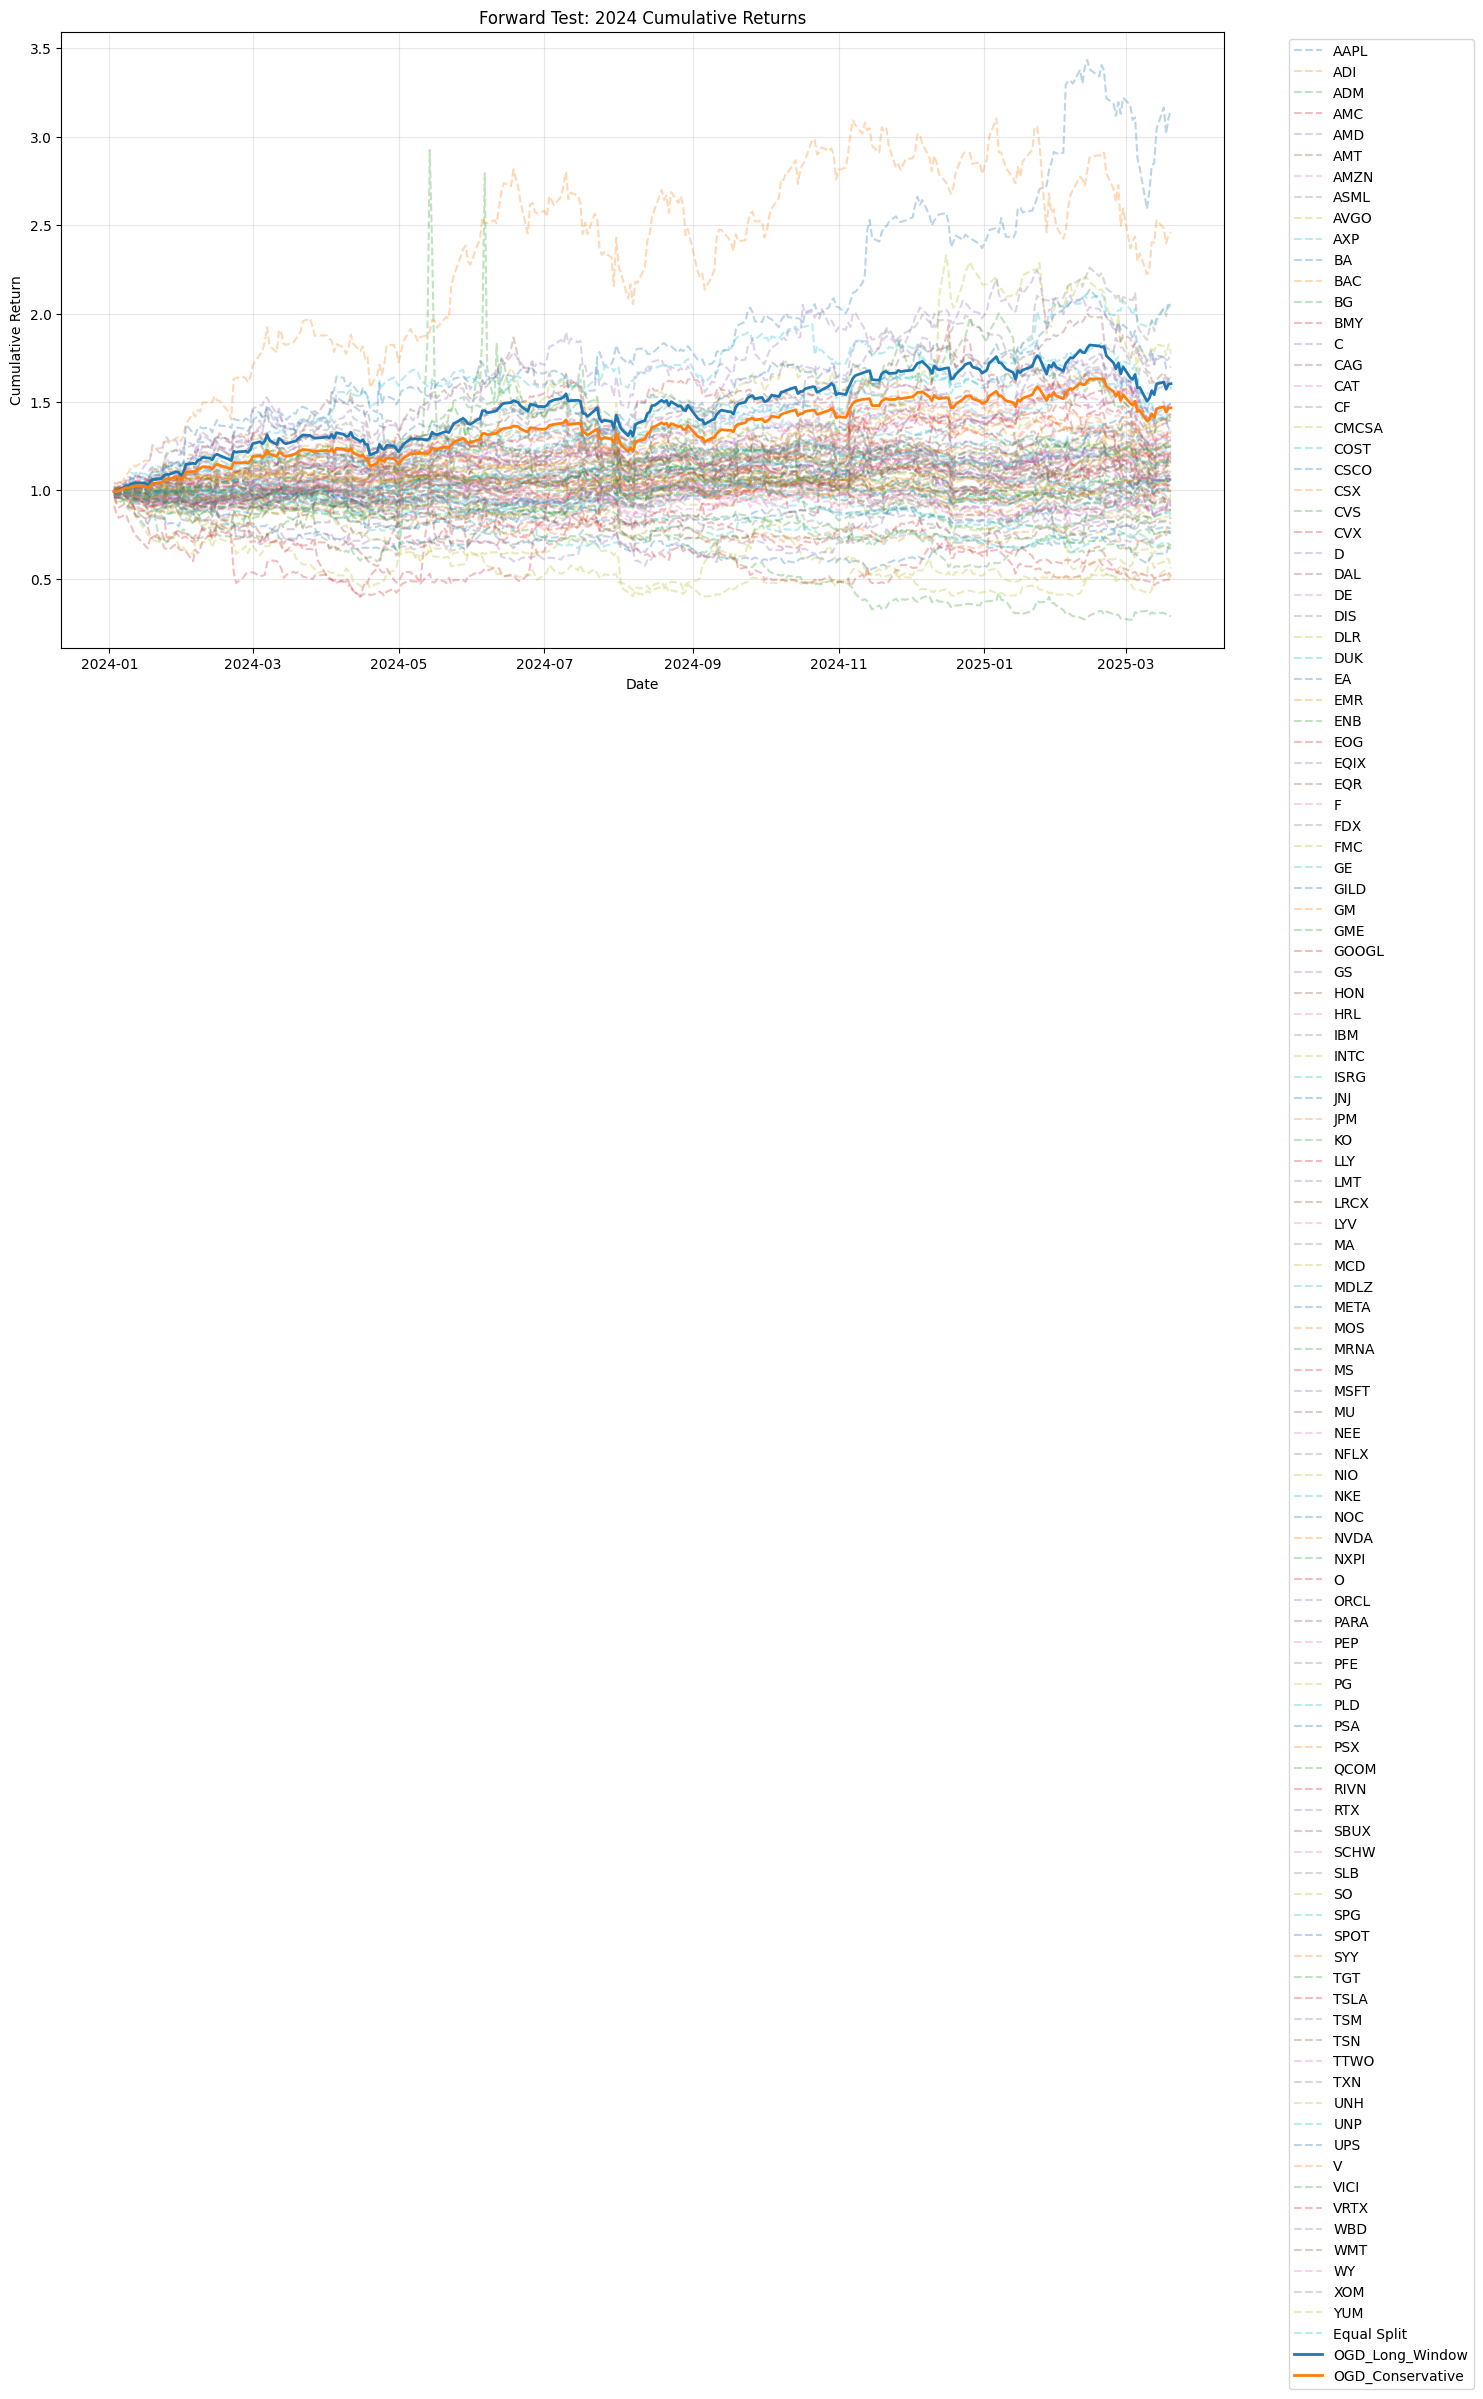

<Figure size 1500x800 with 0 Axes>

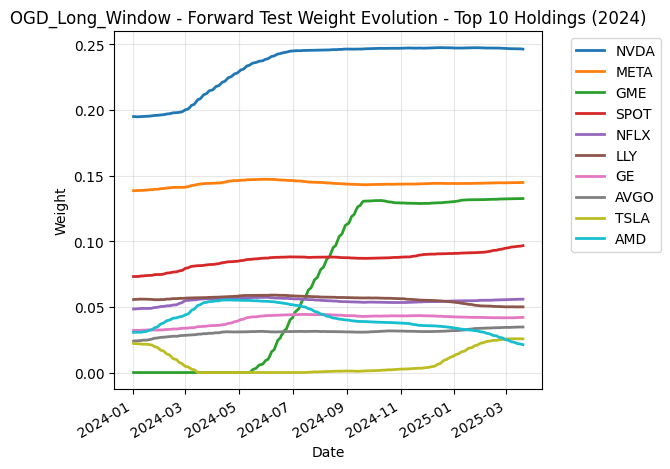

<Figure size 1500x800 with 0 Axes>

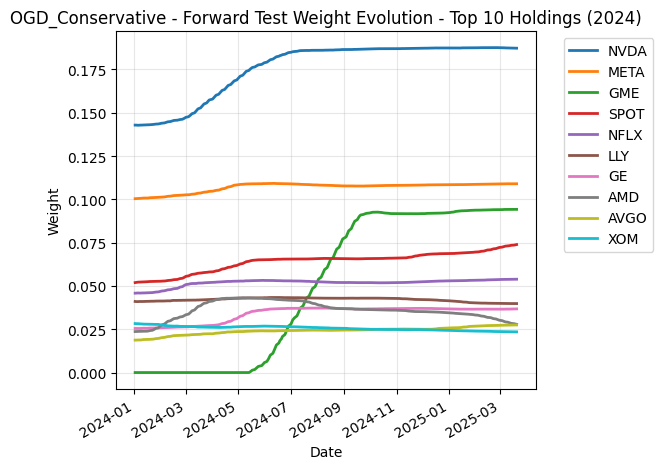


Final Cumulative Returns (2024):
SPOT: 3.15x
NVDA: 2.46x
GE: 2.05x
NFLX: 2.03x
AVGO: 1.78x
TSM: 1.78x
META: 1.70x
WMT: 1.64x
RTX: 1.62x
OGD_Long_Window: 1.60x
IBM: 1.57x
GS: 1.49x
ORCL: 1.49x
ISRG: 1.49x
OGD_Conservative: 1.47x
AXP: 1.46x
LLY: 1.43x
JPM: 1.43x
C: 1.41x
GME: 1.41x
GM: 1.39x
COST: 1.39x
MS: 1.34x
GILD: 1.33x
LYV: 1.33x
SO: 1.33x
V: 1.32x
TTWO: 1.32x
AMZN: 1.30x
BAC: 1.29x
DUK: 1.29x
ENB: 1.28x
MA: 1.28x
MU: 1.26x
YUM: 1.25x
CSCO: 1.25x
VRTX: 1.24x
SPG: 1.22x
BMY: 1.22x
KO: 1.21x
DE: 1.21x
D: 1.21x
NEE: 1.20x
EMR: 1.19x
GOOGL: 1.18x
XOM: 1.18x
DAL: 1.18x
EQR: 1.17x
CAT: 1.17x
Equal Split: 1.17x
DLR: 1.16x
CVX: 1.16x
PG: 1.16x
AAPL: 1.16x
SCHW: 1.16x
QCOM: 1.15x
TSN: 1.13x
TXN: 1.11x
DIS: 1.10x
SBUX: 1.09x
ADI: 1.09x
LRCX: 1.08x
EQIX: 1.08x
MCD: 1.06x
NOC: 1.06x
EA: 1.06x
JNJ: 1.06x
EOG: 1.06x
LMT: 1.06x
MSFT: 1.05x
VICI: 1.05x
HON: 1.04x
ASML: 1.03x
O: 1.03x
AMT: 1.01x
FDX: 1.00x
PSX: 1.00x
PSA: 1.00x
UNP: 0.99x
SYY: 0.99x
CF: 0.97x
UNH: 0.97x
TSLA: 0.95x
PFE: 0.95x
HRL:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Plot results
plt.figure(figsize=(15, 8))

# Plot fundamental strategies with alpha 0.3
for strategy in fundamental_strategies.keys():
    if strategy in all_returns_df.columns:
        plt.plot(all_returns_df[strategy], alpha=0.3, linestyle='--', label=strategy)

# Plot OGD strategies with full opacity
for strategy in forward_results.keys():
    if strategy in all_returns_df.columns:
        plt.plot(all_returns_df[strategy], linewidth=2, label=strategy)

plt.title('Forward Test: 2024 Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the weight evolution for the OGD strategies - TOP 10 STOCKS ONLY
for name, weights_df in forward_weights_history.items():
    plt.figure(figsize=(15, 8))

    # Get the top 10 stocks based on final portfolio weights
    last_weights = weights_df.iloc[-1]
    top10_stocks = last_weights.nlargest(10).index

    # Plot only the top 10 stocks
    weights_df[top10_stocks].plot(linewidth=2)

    plt.title(f'{name} - Forward Test Weight Evolution - Top 10 Holdings (2024)')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Print final cumulative returns
print("\nFinal Cumulative Returns (2024):")
final_returns = {}

# Get the last value for each strategy
for strategy in all_returns_df.columns:
    final_returns[strategy] = all_returns_df[strategy].iloc[-1]

# Sort and print
final_returns = pd.Series(final_returns).sort_values(ascending=False)
for strategy in final_returns.index:
    print(f"{strategy}: {final_returns[strategy]:.2f}x")

# Calculate risk metrics for all strategies
risk_metrics = {}

for strategy in all_returns_df.columns:
    returns = all_returns_df[strategy].pct_change().dropna()

    # Annualized return
    annualized_return = (all_returns_df[strategy].iloc[-1] ** (252 / len(returns)) - 1) * 100

    # Volatility (annualized)
    volatility = returns.std() * torch.sqrt(torch.tensor(252.0, dtype=torch.float32)) * 100

    # Maximum drawdown
    cum_returns = all_returns_df[strategy]
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns / rolling_max - 1) * 100
    max_drawdown = drawdown.min()

    # Sharpe ratio (assuming 2% risk-free rate)
    excess_return = annualized_return - 2.0  # 2% risk-free
    sharpe = excess_return / volatility if volatility > 0 else 0

    risk_metrics[strategy] = {
        'Annual Return (%)': annualized_return,
        'Volatility (%)': volatility,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe
    }

# Create a summary DataFrame
risk_summary = pd.DataFrame(risk_metrics).T
print("\nRisk Metrics (2024):")
print(risk_summary.sort_values('Annual Return (%)', ascending=False).round(2))

# Add information about portfolio concentration
print("\nPortfolio Concentration (Final Weights):")
for name, weights_df in forward_weights_history.items():
    last_weights = weights_df.iloc[-1]

    # Get non-zero positions (greater than 0.5%)
    active_positions = (last_weights > 0.005).sum()

    # Get top 10 concentration
    top10_concentration = last_weights.nlargest(10).sum() * 100

    # Get Herfindahl-Hirschman Index (HHI) - measure of concentration
    hhi = (last_weights ** 2).sum() * 10000  # Scaled by 10000 as is standard

    print(f"\n{name}:")
    print(f"  Active positions (>0.5%): {active_positions}")
    print(f"  Top 10 concentration: {top10_concentration:.2f}%")
    print(f"  HHI concentration index: {hhi:.2f} (higher = more concentrated)")
    print(f"  Top 5 holdings:")

    for i, (stock, weight) in enumerate(last_weights.nlargest(5).items(), 1):
        print(f"    {i}. {stock}: {weight*100:.2f}%")